## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

###  IEEE-CIS Fraud Detection 피쳐 설명
- X_train
    - TransactionDT : 초, 최대값이 15811131 , 183일째 해당
    - TransactionAMT: 거래 결제 금액(USD) + 소수점 세자리는 환율로 의해 계산된 숫자같음. 실제로 그 행의 addr은 빈칸
    - ProductCD: 제품 코드, 각 거래에 대한 제품 + 장바구니 등 실제 상품 뿐만 아니라 모든 서비스일듯?
    - card1 - card6: 카드 종류, 카드 종류, 발행 은행, 국가 등의 결제 카드 정보
    - addr1 - addr2: 주소 (1은 지역, 2는 국가)
    - dist1 - dist2: 거리
    - P_ and (R__) emaildomain: 구매자 및 수신자 이메일 도메인
    - C1 - C14: 지불 카드와 연결된 것으로 확인된 주소 수 등의 계산. 실제 의미는 가려져 있습니다.
    - D1 - D15: 이전 트랜잭션 사이의 날짜 등과 같은 timedelta
    - M1 - M9: 카드의 이름 및 주소 등과 같은 일치
    - Vxxx: Vesta는 순위, 계산 및 기타 엔터티 관계를 포함하여 풍부한 기능을 엔지니어링했습니다.
    
    - Categorical Features:
        ProductCD
        card1 - card6
        addr1, addr2
        P_emaildomain
        R_emaildomain
        M1 - M9
- train_id

    - Categorical Features:
        DeviceType
        DeviceInfo
        id_12 - id_38 : id_0 - id_11은 기기 등급, ip_domain 등급, 프록시 등급 등 Vesta와 보안 파트너가 수집하는 신원에 대한 숫자 기능입니다. 또한 계정 로그인 횟수/로그인 실패 횟수, 계정 기간과 같은 행동 지문을 기록했습니다. 페이지에 머물렀다 등.

## 1. 라이브러리, 데이터 불러오기

In [1]:
#경고무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lightgbm optuna missingno

In [116]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor
from xgboost import XGBClassifier

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

# 결측치 보여주는 라이브러리, missingno
import missingno as msno

# Counter
from collections import Counter

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# sklearn 전처리
from sklearn.preprocessing import LabelEncoder

# gc
import gc

# tqdm
from tqdm import tqdm_notebook

In [4]:
# 메모리 줄이기 위해 데이터프레임의 모든 컬럼 반복과 데이터타입 변경

def reduce_mem_usage(df):
    start_mem= df.memory_usage().sum() /1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for cil in df.columns:
        col_type = df[col].dtype
        
        if col_type !=object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] =='int':
                if c_min > np.iinfo(np.int8).min and c_max< np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >np.iinfo(np.int16).min and c_max <np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >np.iinfo(np.int32).min and c_max <np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >np.iinfo(np.int64).min and c_max <np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                
            else:
                if c_min >np.finfo(np.float16).min and c_max <np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >np.finfo(np.float32).min and c_max <np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
                    
    end_mem=df.memory_usage().sum()/ 1024**2
    print("Memory usage after optimization is : {:.2f} MB".format(end_mem))
    print('Decrease by {:.1f}%'.format(100*(start_mem -end_mem)/start_mem))
    return df                   

In [5]:
%%time

folder_path = '../Dataset/Fraud/'

train_identity = pd.read_csv(f"{folder_path}train_identity.csv", index_col='TransactionID')

train_transaction = pd.read_csv(f"{folder_path}train_transaction.csv",index_col='TransactionID')

test_identity = pd.read_csv(f"{folder_path}test_identity.csv", index_col='TransactionID')

test_transaction = pd.read_csv(f"{folder_path}test_transaction.csv",index_col='TransactionID')


sub = pd.read_csv(f'{folder_path}sample_submission.csv')

print('데이터 로드 완료')

데이터 로드 완료
CPU times: total: 20.9 s
Wall time: 20.9 s


In [ ]:
# useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
#                    'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
#                    'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
#                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
#                    'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
#                    'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
#                    'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
#                    'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
#                    'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
#                    'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
#                    'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
#                    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
#                    'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
#                    'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
#                    'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
#                    'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
#                    'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
#                    'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
#                    'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
#                    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
#                    'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [6]:
# test_identity 하이픈을 언더바로 바꾸는 작업
columns=[]
for idx, col in enumerate(test_identity.columns):

    if "-" in col:
        col =col.replace("-","_")
    columns.append(col)

test_identity.columns = columns



In [7]:
def id_split(df):
    # split 옵션으로 expand= True를 넣으면 바로 나눠진대로 데이터프레임에 컬럼을 생성한다.
    df['device_name'] = df['DeviceInfo'].str.split("/", expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]
    
    df['OS_id_30']= df['id_30'].str.split(" ", expand=True)[0]
    df['version_id_30']= df['id_30'].str.split(" ", expand=True)[1]
    
    df['browser_id_31'] = df['id_31'].str.split(" ", expand=True)[0]
    df['version_id_31'] = df['id_31'].str.split(" ", expand=True)[1]
    
    df['screen_width'] = df['id_33'].str.split('x',expand=True)[0]
    df['screen_height'] = df['id_33'].str.split('x',expand=True)[1]
    
    df['id_34'] =df['id_34'].str.split(':', expand =True)[1]
    df['id_23'] =df['id_23'].str.split(':', expand =True)[1]
    
    
    # contains에 na 옵션 True 주면 NaN값도 검색에 포함, False주면 안포함, na옵션 아예 없이 검색했는데 NaN값 있으면 오류.
    df.loc[df['device_name'].str.contains("SM", na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains("SAMSUNG", na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains("GT-", na=False), 'device_name'] = 'Samsung'
    
    df.loc[df['device_name'].str.contains("Moto G", na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains("Moto", na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains("moto", na=False), 'device_name'] = 'Motorola'
    
    df.loc[df['device_name'].str.contains("LG-", na=False), 'device_name'] = 'LG'
    
    df.loc[df['device_name'].str.contains("rv:", na=False), 'device_name'] = 'RV'
    
    df.loc[df['device_name'].str.contains("HUAWEI", na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains("ALE-", na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains("-L", na=False), 'device_name'] = 'Huawei'
    
    df.loc[df['device_name'].str.contains("Blade", na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains("BLADE", na=False), 'device_name'] = 'ZTE'
    
    df.loc[df['device_name'].str.contains("Linux", na=False), 'device_name'] = 'Linux'
    
    df.loc[df['device_name'].str.contains("XT", na=False), 'device_name'] = 'Sony'
    
    df.loc[df['device_name'].str.contains("HTC", na=False), 'device_name'] = 'HTC'
    
    df.loc[df['device_name'].str.contains("ASUS", na=False), 'device_name'] = 'Asus'
    
    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() <200].index), 'device_name'] ='Others'
    df['had_id'] =1
    gc.collect()
    
    return df

In [8]:
# 적용
train_identity = id_split(train_identity)
test_identity = id_split(test_identity)

In [9]:
# 데이터 merge
print("Merging data ...")

# merge 옵션에 left_index=True, right_index =True 주면 inner join같이 같은 인덱스만 가져옴, 그런데 how='left' 주면 left join과 같은 기능
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Merged")

del train_identity, train_transaction, test_identity, test_transaction

print("train", train.shape)
print("test", test.shape)

gc.collect()


Merging data ...
Merged
train (590540, 442)
test (506691, 441)


44

In [39]:
columns_a=['TransactionAmt','id_02','D15']
columns_b = ['card1','card4','addr1']

for col_a in columns_a:
    for col_b in columns_b:
        for df in [train,test]:
            # transform은 그냥 집계함수랑 달리 중복도 나옴 -> 전체 인덱스가 나옴 why? 그냥 col_a가 있으면 그 값인 col_b 들을 평균한거 각각 인덱스마다 다 붙여줌.
            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform("mean")
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform("std")

In [72]:
# 새 피쳐 - transaction금액 로그값
train['Transaction_Log'] = np.log(train['TransactionAmt'])
test['Transaction_Log'] = np.log(test['TransactionAmt'])

# # 새 피쳐 - 소수점만 *1000 곱해서 추출한 피쳐
train['Transaction_decimal'] = ((train['TransactionAmt']-train['TransactionAmt'].astype(int))*1000 ).astype(int)
test['Transaction_decimal'] = ((test['TransactionAmt']-test['TransactionAmt'].astype(int))*1000 ).astype(int)

# # 새 피쳐 - 거래 일어난 요일 DT가 초단위여서 하루단위로 바꾸려면 한시간(3600초) * 24시로 나눈다 1을 왜 빼는지는 모르겠음.
train['Transaction_day_of_week'] = np.floor(    (train['TransactionDT']/(3600*24) -1)%7     )
test['Transaction_day_of_week'] = np.floor(    (test['TransactionDT']/(3600*24) -1)%7     )

# # 새 피쳐 - 거래 일어난 시간대 (0~24)
train['Transaction_hour'] = np.floor(train['TransactionDT']/3600) %24
test['Transaction_hour'] = np.floor(test['TransactionDT']/3600) %24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8','D11__DeviceInfo','DeviceInfo__P_emaildomain','P_emaildomain__C2', 'card2__dist1','card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:
    
    f1, f2= feature.split("__")
    train[feature] = train[f1].astype(str) + "_" + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + "_" + test[f2].astype(str)
    
    le = LabelEncoder()
    le.fit( list(train[feature].astype(str).values) + list(test[feature].astype(str).values) )
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

# 인코딩 - train과 test 인코딩 카운트
for feature in ['card1','card2','card3','card4','card5','card6','id_36']:
    train[feature + "_count_full"] = train[feature].map(pd.concat([train[feature],test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + "_count_full"] = test[feature].map(pd.concat([train[feature],test[feature]], ignore_index=True).value_counts(dropna=False))


# 인코딩 - train과 test 각각 카운트 value_counts() 옵션에 dropna False로 주면 nan까지 다 센다. 그걸 각각 인덱스에 다 부여
for feature in ['id_01','id_31','id_33','id_36']:
    train[feature +"_count_dist"] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature +"_count_dist"] = test[feature].map(test[feature].value_counts(dropna=False))



In [73]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [89]:
# Cleaning P_emaildomain and R_emaildomain

for c in ['P_emaildomain','R_emaildomain']:
    train[c + "_bin"] = train[c].map(emails)
    test[c+ "_bin"] = test[c].map(emails)
    
    train[c + "_suffix"] = train[c].map(lambda x: str(x).split(".")[-1])
    test[c + "_suffix"] = test[c].map(lambda x: str(x).split(".")[-1])
    
    train[c+ "_suffix"] =train[c+ '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c+ "_suffix"] =test[c+ '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [90]:
%%time

for col in train.columns:
    if train[col].dtype =='object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

CPU times: total: 53.3 s
Wall time: 53.3 s


In [94]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2102.15 MB
Memory usage after optimization is : 2100.46 MB
Decrease by 0.1%
Memory usage of dataframe is 1802.10 MB
Memory usage after optimization is : 1800.65 MB
Decrease by 0.1%
CPU times: total: 1.09 s
Wall time: 1.12 s


In [105]:
# TransactionDT로 정렬하고 컬럼2개 드랍한 뒤 X에 대입

X = train.sort_values("TransactionDT").drop(['isFraud','TransactionDT'], axis=1)
y = train.sort_values("TransactionDT")['isFraud']

X_test = test.drop(['TransactionDT'], axis=1)

del train, test

gc.collect()

6117

In [106]:
from sklearn.model_selection import KFold
import lightgbm as lgb

In [118]:
params ={'num_leaves':491,
        'min_child_weight' : 0.03454472573214212,
         'feature_fraction': 0.3797454081646243,
         'bagging_fraction': 0.4181193142567742,
         'min_data_in_leaf': 106,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.006883242363721497,
         'boosting_type':'gbdt',
         'bagging_seed':11,
         "metric": 'auc',
         'verbosity':-1,
         'reg_alpha': 0.3899927210061127,
         'reg_lambda': 0.6485237330340494,
         'random_state' :47,
        }

In [120]:
%%time

NFOLDS = 5
folds= KFold(n_splits=NFOLDS)

columns= X.columns
splits = folds.split(X,y)          # split은 매개변수로 들어온 것 인덱스로 나눠준다.
y_preds= np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score =0

feature_importances= pd.DataFrame()
feature_importances['feature'] = columns

for fold_n, (train_index,valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(params, dtrain, 10000, valid_sets=[dtrain,dvalid], verbose_eval =200, early_stopping_rounds =500)
    
    feature_importances[f"fold_{fold_n +1}"] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n +1} | AUC : {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds +=clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train,y_valid
    
    gc.collect()
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.956279	valid_1's auc: 0.888945
[400]	training's auc: 0.977444	valid_1's auc: 0.902248
[600]	training's auc: 0.98913	valid_1's auc: 0.910656
[800]	training's auc: 0.994887	valid_1's auc: 0.915512
[1000]	training's auc: 0.99763	valid_1's auc: 0.918232
[1200]	training's auc: 0.998921	valid_1's auc: 0.919638
[1400]	training's auc: 0.99948	valid_1's auc: 0.920325
[1600]	training's auc: 0.999757	valid_1's auc: 0.920759
[1800]	training's auc: 0.999886	valid_1's auc: 0.921124
[2000]	training's auc: 0.999952	valid_1's auc: 0.921322
[2200]	training's auc: 0.999981	valid_1's auc: 0.921552
[2400]	training's auc: 0.999992	valid_1's auc: 0.921842
[2600]	training's auc: 0.999997	valid_1's auc: 0.922094
[2800]	training's auc: 0.999999	valid_1's auc: 0.922217
[3000]	training's auc: 0.999999	valid_1's auc: 0.92226
[3200]	training's auc: 1	valid_1's auc: 0.922263
[3400]	training's auc: 1	valid_1's auc: 0.922203
Early st

In [122]:
sub['isFraud'] =y_preds
sub.to_csv("submission.csv", index=False)

Text(0.5, 1.0, '50 TOP feature over 5 folds average')

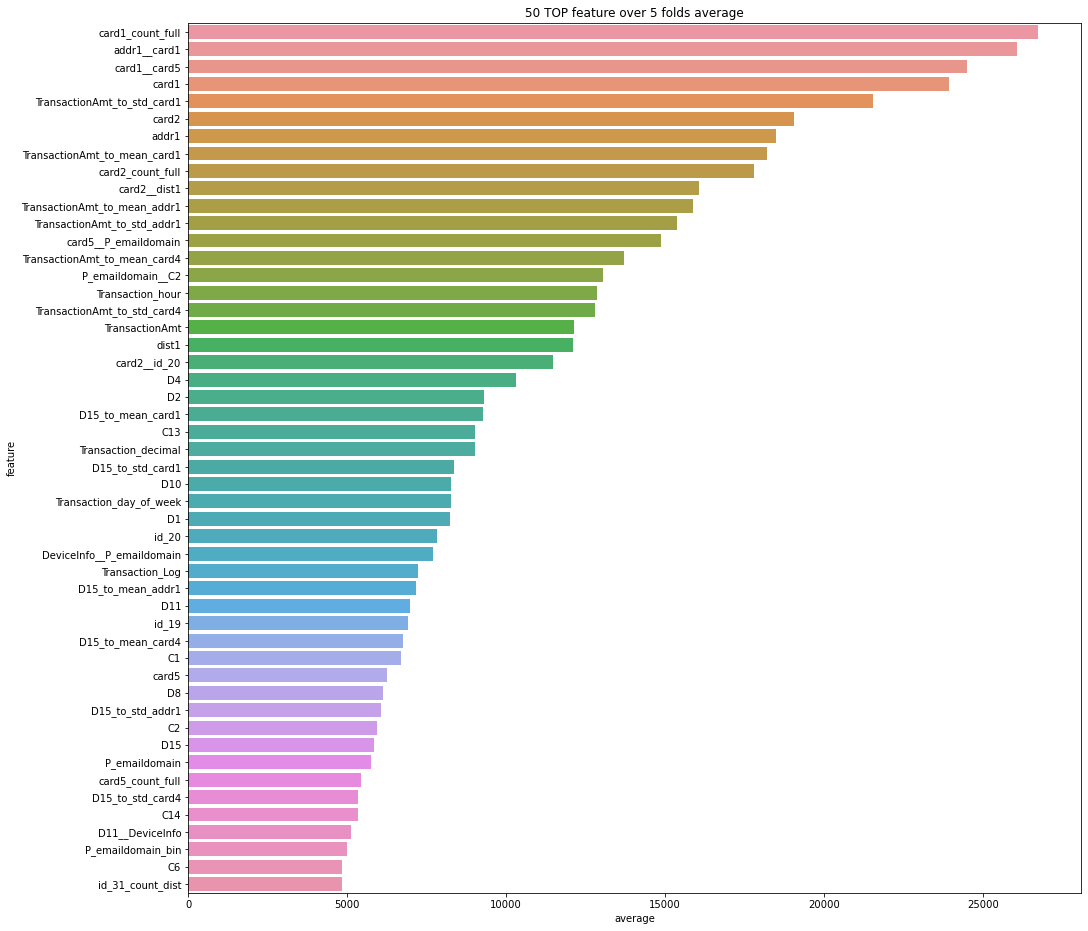

In [125]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n +1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv("feature_importances.csv")

plt.figure(figsize= (16,16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title("50 TOP feature over 5 folds average")

In [124]:
[f'fold_{fold_n +1}' for fold_n in range(folds.n_splits)]

['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5']

In [112]:

NFOLDS = 5
folds= KFold(n_splits=NFOLDS)
splits = folds.split(X,y)

for a,(b,c) in enumerate(splits):
    print(f'a={a},b={b}')
    print(f'c={c}')

a=0,b=[118108 118109 118110 ... 590537 590538 590539]
c=[     0      1      2 ... 118105 118106 118107]
a=1,b=[     0      1      2 ... 590537 590538 590539]
c=[118108 118109 118110 ... 236213 236214 236215]
a=2,b=[     0      1      2 ... 590537 590538 590539]
c=[236216 236217 236218 ... 354321 354322 354323]
a=3,b=[     0      1      2 ... 590537 590538 590539]
c=[354324 354325 354326 ... 472429 472430 472431]
a=4,b=[     0      1      2 ... 472429 472430 472431]
c=[472432 472433 472434 ... 590537 590538 590539]


In [95]:
train.sort_values("TransactionDT")

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,card6_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,4,13926,NaN,150.0,1,142.0,1,...,267648,819269,446307,450258,517251,449555,6,6,6,6
2987001,0,86401,29.00,4,2755,404.0,150.0,2,102.0,1,...,267648,819269,446307,450258,517251,449555,4,0,6,6
2987002,0,86469,59.00,4,4663,490.0,150.0,4,166.0,2,...,824959,819269,446307,450258,517251,449555,5,0,6,6
2987003,0,86499,50.00,4,18132,567.0,150.0,2,117.0,2,...,824959,819269,446307,450258,517251,449555,9,0,6,6
2987004,0,86506,50.00,1,4497,514.0,150.0,2,102.0,1,...,267648,267353,19555,1061,544,134066,4,0,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.00,4,6550,NaN,150.0,4,226.0,2,...,824959,819269,446307,450258,517251,449555,6,6,6,6
3577536,0,15811049,39.50,4,10444,225.0,150.0,2,224.0,2,...,824959,819269,446307,450258,517251,449555,4,0,6,6
3577537,0,15811079,30.95,4,12037,595.0,150.0,2,224.0,2,...,824959,819269,446307,450258,517251,449555,4,0,6,6


In [66]:
train['id_01'].map(train['id_01'].value_counts(dropna=False))

TransactionID
2987000    446307
2987001    446307
2987002    446307
2987003    446307
2987004     19555
            ...  
3577535    446307
3577536    446307
3577537    446307
3577538    446307
3577539    446307
Name: id_01, Length: 590540, dtype: int64

In [71]:
train['id_01'].value_counts(dropna=False)

 NaN     446307
-5.0      82170
 0.0      19555
-10.0     11257
-20.0     11211
          ...  
-89.0         1
-93.0         1
-24.0         1
-94.0         1
-51.0         1
Name: id_01, Length: 78, dtype: int64

In [60]:
train[feature].value_counts()

F    134066
T      6919
Name: id_36, dtype: int64

In [42]:
((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)

TransactionID
2987000    500
2987001      0
2987002      0
2987003      0
2987004      0
          ... 
3577535      0
3577536    500
3577537    949
3577538      0
3577539    949
Name: TransactionAmt, Length: 590540, dtype: int32

In [51]:
train["id_20"].astype(str).values

array(['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'], dtype=object)

In [7]:
# 데이터 불러오기
base_path = "../Dataset/Fraud/"

train = pd.read_csv(base_path + "train_transaction.csv")
train_id = pd.read_csv(base_path+"train_identity.csv")

test= pd.read_csv(base_path + "test_transaction.csv")
test_id= pd.read_csv(base_path + "test_identity.csv")


In [11]:
# train 을 X와 y 데이터로 나눔.
y_train= train.isFraud

X_train = train.drop(['isFraud'], axis=1)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.7+ GB


In [21]:
X_train

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [23]:
X_train.ProductCD.unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

In [22]:
train_id

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,NaN,427.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,-300.0,New,NotFound,166.0,15.0,352.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.1.1,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,27.0,567.0,411.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,-300.0,Found,Found,166.0,15.0,352.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_9_5,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [ ]:
## On your Own
data.columns.value_counts()
sns.countplot()
sns.histplot()
...

<AxesSubplot:xlabel='y', ylabel='Count'>

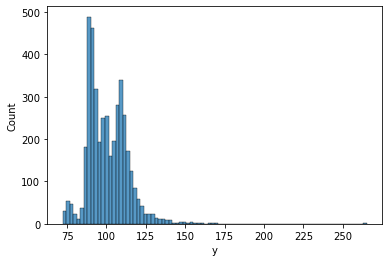

In [11]:
# 타겟 분포

sns.histplot(y)

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [12]:
# 결측치가 있는 column  --> 없다.

X[X.isnull().any(axis=1)]

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [13]:
# 컬럼 dtype이 object인 경우 " " 값이 있는지 확인.  --> 없다.
blank =" "
for i in range(8):
 if blank in X.iloc[:,i].unique():
        print(i)

In [14]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
correlated_features = X.corr()

In [17]:
correlated_features

,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
X10,1.000000,NaN,-0.033084,-0.028806,-0.100474,-0.002532,-0.005944,-0.010164,-0.010323,-0.038610,...,0.165277,-0.028618,-0.074244,-0.016870,-0.011374,-0.010479,-0.010164,-0.004740,-0.002532,-0.004387
X11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X12,-0.033084,NaN,1.000000,0.214825,-0.246513,-0.006212,-0.014584,-0.024937,-0.025327,-0.094730,...,-0.107864,-0.070214,0.030134,-0.016043,-0.027907,-0.005566,-0.024937,-0.011628,-0.006212,-0.010765
X13,-0.028806,NaN,0.214825,1.000000,-0.083141,-0.005409,-0.012698,-0.021713,-0.010525,-0.082482,...,-0.169721,-0.061136,0.357229,-0.036040,-0.024299,0.023045,-0.021713,-0.010125,0.041242,-0.009373
X14,-0.100474,NaN,-0.246513,-0.083141,1.000000,-0.018865,-0.044291,0.012713,-0.076916,-0.287691,...,0.118950,0.026496,-0.097464,-0.037958,0.103309,0.007743,0.012713,0.023604,0.025199,0.043667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X380,-0.010479,NaN,-0.005566,0.023045,0.007743,-0.001968,-0.004619,-0.007899,-0.008022,-0.021140,...,-0.061741,-0.022240,-0.061168,-0.013110,-0.008839,1.000000,-0.007899,-0.003683,-0.001968,-0.003410
X382,-0.010164,NaN,-0.024937,-0.021713,0.012713,-0.001908,-0.004480,1.000000,0.085256,-0.029102,...,-0.059883,-0.021571,-0.059327,-0.012716,-0.008573,-0.007899,1.000000,-0.003572,-0.001908,-0.003307
X383,-0.004740,NaN,-0.011628,-0.010125,0.023604,-0.000890,-0.002089,-0.003572,0.062481,-0.013571,...,-0.015413,-0.010059,0.035107,-0.005930,-0.003998,-0.003683,-0.003572,1.000000,-0.000890,-0.001542
X384,-0.002532,NaN,-0.006212,0.041242,0.025199,-0.000475,-0.001116,-0.001908,-0.001938,-0.007250,...,-0.014917,-0.005373,0.008694,-0.003168,-0.002136,-0.001968,-0.001908,-0.000890,1.000000,-0.000824


In [15]:
# 이 인덱스들은 전부 값이 0  --> 삭제 요망
print(correlated_features["X10"][correlated_features['X10'].isnull()].index)
for i in correlated_features["X10"][correlated_features['X10'].isnull()].index:
    print(X[i].unique())

Index(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293',
       'X297', 'X330', 'X347'],
      dtype='object')
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [16]:
# 모든 값이 0인 컬럼 삭제
cond = list(correlated_features["X10"][correlated_features['X10'].isnull()].index)
X = X.drop(cond, axis=1)
test =test.drop(cond,axis=1)

#### 다중공선성 처리

In [17]:
# 다중공선성 확인
temp = []
indices= []
for i in correlated_features.columns:
    for j in correlated_features.loc[:,i].index:
        if (correlated_features.loc[j,i] >=0.8) &(i != j):
            if (j,i) not in temp:
                print(f"컬럼{i}에서 컬럼{j}와 큰 상관관계")
                temp.append((i,j))

for i,j in temp:
    indices.append(i)

컬럼X14에서 컬럼X191와 큰 상관관계
컬럼X14에서 컬럼X251와 큰 상관관계
컬럼X17에서 컬럼X325와 큰 상관관계
컬럼X17에서 컬럼X382와 큰 상관관계
컬럼X19에서 컬럼X215와 큰 상관관계
컬럼X28에서 컬럼X148와 큰 상관관계
컬럼X29에서 컬럼X54와 큰 상관관계
컬럼X29에서 컬럼X76와 큰 상관관계
컬럼X29에서 컬럼X162와 큰 상관관계
컬럼X29에서 컬럼X166와 큰 상관관계
컬럼X29에서 컬럼X232와 큰 상관관계
컬럼X29에서 컬럼X272와 큰 상관관계
컬럼X29에서 컬럼X276와 큰 상관관계
컬럼X29에서 컬럼X279와 큰 상관관계
컬럼X29에서 컬럼X328와 큰 상관관계
컬럼X31에서 컬럼X35와 큰 상관관계
컬럼X31에서 컬럼X37와 큰 상관관계
컬럼X33에서 컬럼X39와 큰 상관관계
컬럼X35에서 컬럼X37와 큰 상관관계
컬럼X44에서 컬럼X302와 큰 상관관계
컬럼X44에서 컬럼X317와 큰 상관관계
컬럼X45에서 컬럼X161와 큰 상관관계
컬럼X45에서 컬럼X202와 큰 상관관계
컬럼X45에서 컬럼X247와 큰 상관관계
컬럼X47에서 컬럼X267와 큰 상관관계
컬럼X48에서 컬럼X66와 큰 상관관계
컬럼X48에서 컬럼X113와 큰 상관관계
컬럼X48에서 컬럼X134와 큰 상관관계
컬럼X48에서 컬럼X147와 큰 상관관계
컬럼X48에서 컬럼X170와 큰 상관관계
컬럼X48에서 컬럼X198와 큰 상관관계
컬럼X48에서 컬럼X222와 큰 상관관계
컬럼X49에서 컬럼X129와 큰 상관관계
컬럼X53에서 컬럼X102와 큰 상관관계
컬럼X53에서 컬럼X214와 큰 상관관계
컬럼X53에서 컬럼X239와 큰 상관관계
컬럼X53에서 컬럼X308와 큰 상관관계
컬럼X53에서 컬럼X370와 큰 상관관계
컬럼X54에서 컬럼X76와 큰 상관관계
컬럼X54에서 컬럼X162와 큰 상관관계
컬럼X54에서 컬럼X166와 큰 상관관계
컬럼X54에서 컬럼X232와 큰 상관관계
컬럼X54에서 컬럼X272와 큰 상관관계
컬럼X54에서 컬럼X276와 큰 상

In [18]:
# 상관관계 0.8 이상인 열 삭제
indices_=Counter(indices)
indices_
X_index = []
for idx, tem in indices_.items():
    if tem >=1:
        X_index.append(idx)
        
X = X.drop(X_index, axis=1)

#### Encoding Categorical Features

In [24]:
X_ = X.drop(columns=object_idx, axis=1)

In [25]:
X_

,X10,X12,X13,X15,X16,X18,X20,X21,X22,X23,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# dtype이 object인 변수들 처리.
X_OHE = pd.get_dummies(X, columns= object_idx)

X_OHE

,X10,X12,X13,X15,X16,X18,X20,X21,X22,X23,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4206,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [23]:
# PCA 적용
from sklearn.decomposition import PCA

if feature_reducing:
    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_data = pca.fit_transform(X_OHE)
    X_train = pd.DataFrame(data=pca_data)

In [29]:
y_train =y
y_train

0       130.81
1        88.53
2        76.26
3        80.62
4        78.02
         ...  
4204    107.39
4205    108.77
4206    109.22
4207     87.48
4208    110.85
Name: y, Length: 4209, dtype: float64

### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = 
y =

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

### 5. 학습 및 평가

In [26]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [30]:
print("\nFitting LightGBM...")
model.fit(X_, y_train)


Fitting LightGBM...
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.345. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.345. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf

LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.0025, max_bin=20,
              metric='mae', min_data=500, min_hessian=0.05, num_leaves=512,
              objective='regression', sub_feature=0.345, verbose=2)

In [31]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = r2_score

In [32]:
print("Prediction")
pred_train = model.predict(X_)
# pred_test = model.predict(test)


train_score = evaluation_metric(y_train, pred_train)
# test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
#print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.1293


### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [33]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.345. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40
Best Estimator :  LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.003, max_bin=20,
              max_depth=8, metric='mae', min_data=500, min_hessian=0.05,
              n

In [34]:
# best hyper-parameter 조합을 두었습니다.

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.003,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 256,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : -1,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

gcv = LGBMRegressor(**param_grid)

In [35]:
# 베스트 모델 학습
print("\nFitting LightGBM...")
gcv.fit(X_, y_train)


Fitting LightGBM...


LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.003, max_bin=20,
              metric='mae', min_data=500, min_hessian=0.05, num_leaves=256,
              objective='regression', sub_feature=0.345, verbose=-1)

In [37]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_)
#gcv_pred_test = gcv.predict(X_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
#gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train R2 Score : %.4f" % gcv_train_score)
#print("Test MAE Score : %.4f" % gcv_test_score)

Prediction with Best Estimator
Train R2 Score : 0.1506


In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

In [ ]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)